# House Prices Regression Analysis
This notebook follows a complete pipeline: EDA, preprocessing, modeling, and evaluation using linear models.

In [7]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plot aesthetics
sns.set_context("paper", rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})  
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score

# Dimensionality reduction (optional)
from sklearn.decomposition import PCA

# Inline plotting for Jupyter
%matplotlib inline


##  Load and Inspect the Data

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Train Shape:",train.shape)
print(train.head())

Train Shape: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice

In [9]:
print("Test Shape:",train.shape)
print(test.head())

Test Shape: (1460, 81)
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondi

In [10]:
#check for data leakage between the test and train dataset using ID feature 
overlap = set(train['Id']).intersection(set(test['Id']))
print("Number of Overlapping values:", len(overlap))

#we are good! no data leakage according to common ID numbers 

Number of Overlapping values: 0


In [11]:
#set ID to index for the train datasets
train.set_index('Id', inplace=True) 
train.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [12]:
#set ID to index for the test datasets
test.set_index('Id', inplace=True) 
test.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


## Check for and Handle Missing Values

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64


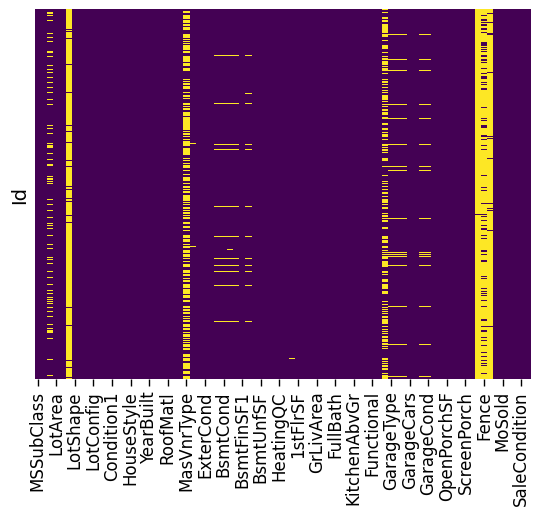

In [13]:
# Check for null values using .info(), isnull().any()
print(train.isnull().sum())
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis');


In [14]:

# Drop columns with >40% missing values like alley, PoolQC because we have too many features
drop_cols = train.columns[train.isnull().mean() > 0.4]
train.drop(columns=drop_cols, inplace=True)

#we have to drop the same columns from the test set
test.drop(columns=drop_cols, inplace=True)

# Impute missing values

#finding which columns are numerical vs categorical because there are over 80
num_cols = train.select_dtypes(include=['float64', 'int64']).drop(columns=['SalePrice']).columns
cat_cols = train.select_dtypes(include='object').columns

#instantiate the imputers 
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

#transform the imputers
train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])

#just checking if sale price our target variable has any nulls
print(train['SalePrice'].isnull().sum())


0


In [15]:
#Sanity check on the null values and new number of columns
print("Train shape:", train.shape)
print("Train nulls:", train.isnull().sum())
print("-"*30)
print("Test shape:", test.shape)
print("Test nulls:", test.isnull().sum())

Train shape: (1460, 74)
Train nulls: MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 74, dtype: int64
------------------------------
Test shape: (1459, 73)
Test nulls: MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 73, dtype: int64


## Exploratory Data Analysis (EDA)

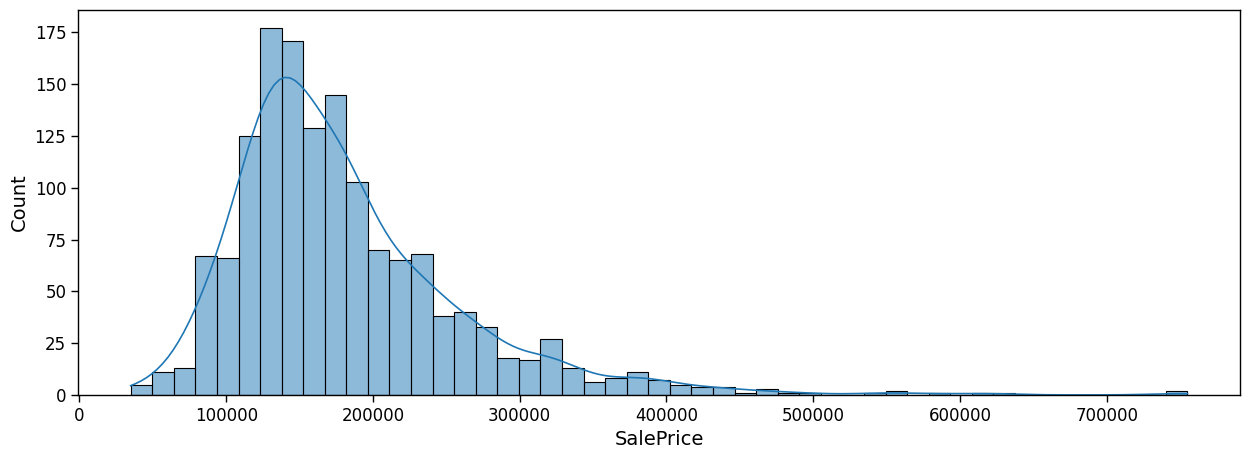

In [16]:
# Histogram to check the distribution of our target variable
plt.figure(figsize=(15, 5))
sns.histplot(data=train, x="SalePrice", kde=True)
plt.show()

In [17]:
# 1) Print the skewness
# 2) print the kurtosis

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

# a lot of kurtosis because it has a really long tail

Skewness: 1.882876
Kurtosis: 6.536282


##### Independent variables: check the statistical properties of the numerical features 

In [18]:
# Get the statistical properties of the numerical features

train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


##### Correlation heatmap 

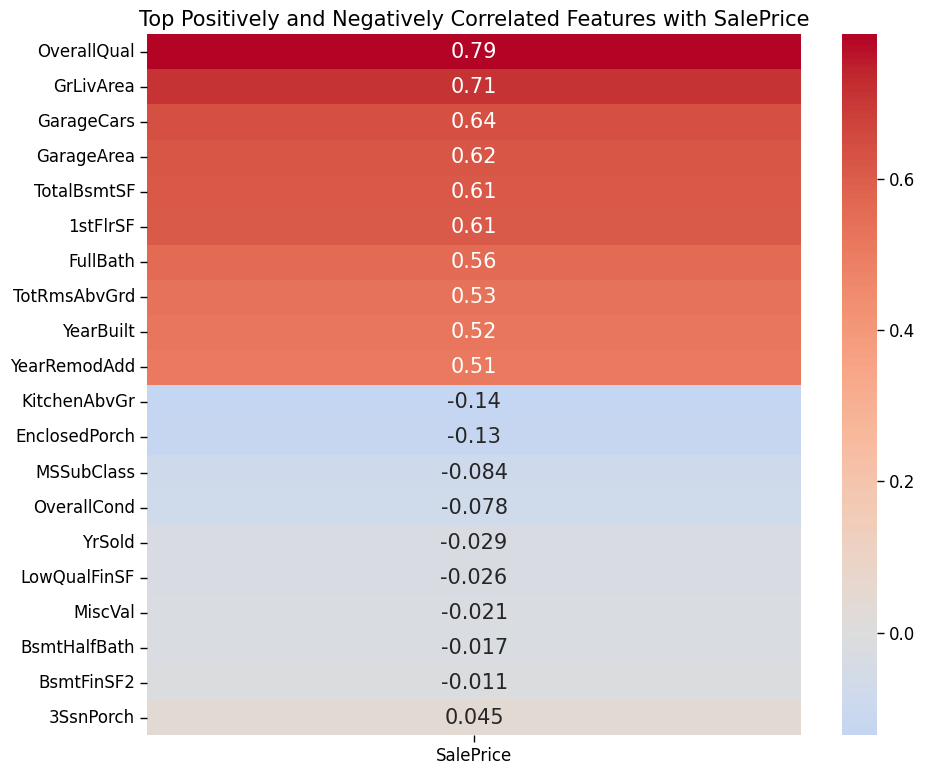

In [19]:
# Get correlation matrix
corr_matrix = train.corr(numeric_only=True)

# Correlation with SalePrice
corr_target = corr_matrix['SalePrice'].drop('SalePrice')

# Get top 10 positively and 10 negatively correlated features
top_pos_corr = corr_target.sort_values(ascending=False).head(10)
top_neg_corr = corr_target.sort_values().head(10)
combined_corr = pd.concat([top_pos_corr, top_neg_corr])

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Top Positively and Negatively Correlated Features with SalePrice")
plt.tight_layout()
plt.show()


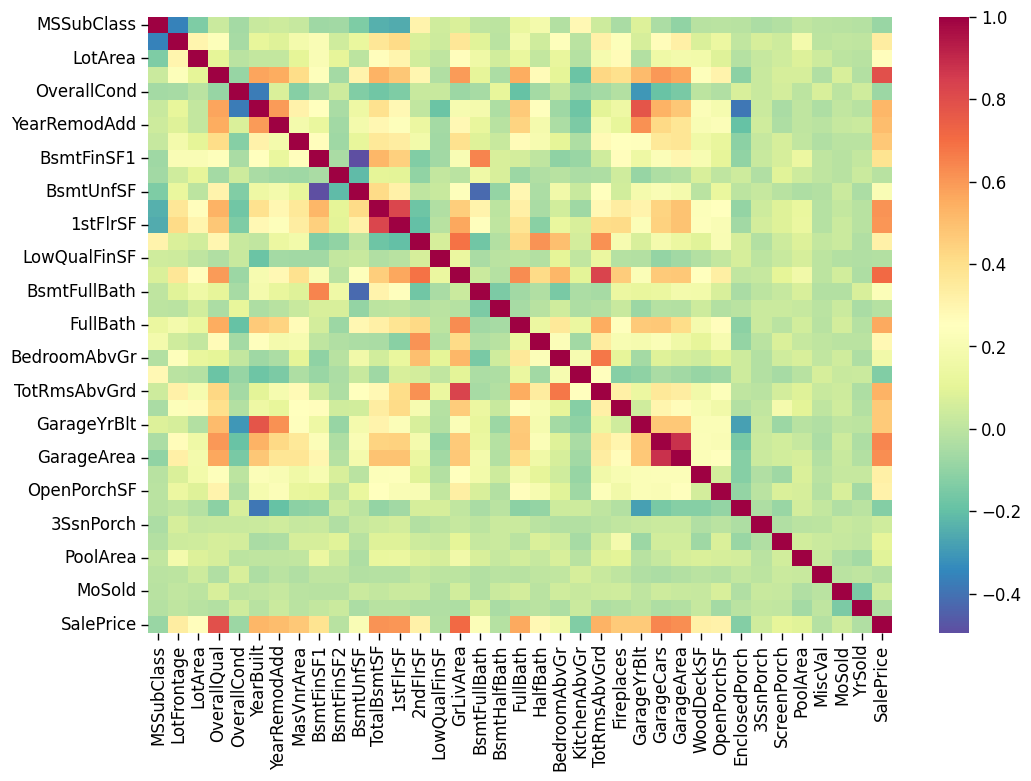

In [20]:
#Traditional sns box plot of the features against one another instead of our target variable
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot_kws={'size': 8}, 
            cmap="Spectral_r");

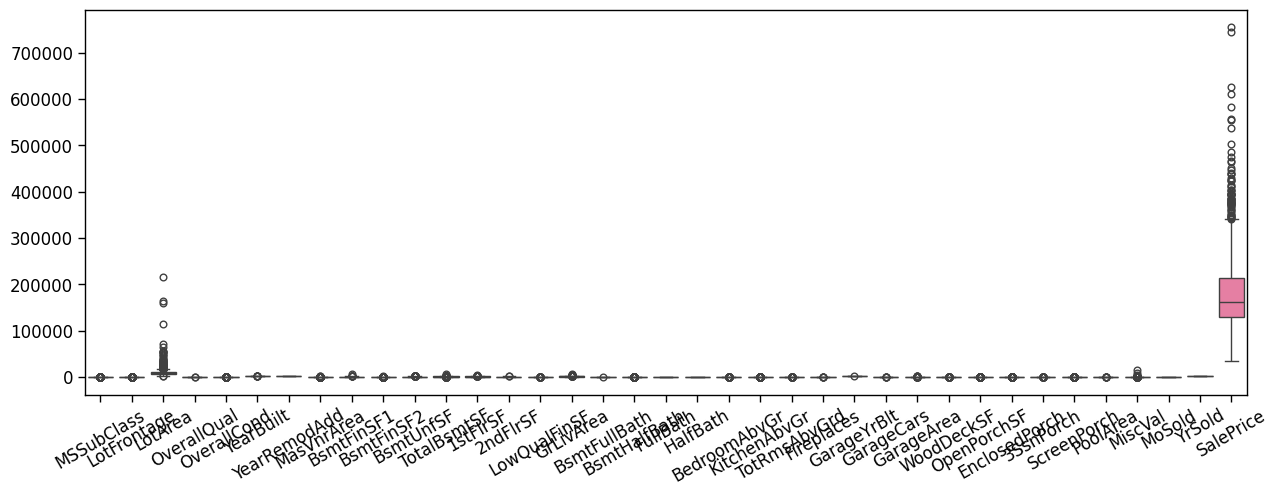

In [21]:
#check on features scale against one another 

plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

Encoding and Scaling

In [ ]:
#Ordinal encoding for certain features that are quality-based or ranked metrics

# One-hot encoding
train_encoded = pd.get_dummies(train, drop_first=True)
test_encoded = pd.get_dummies(test, drop_first=True)

# Align columns
X = train_encoded.drop(columns=['SalePrice', 'Id'])
y = train_encoded['SalePrice']
X_test = test_encoded.reindex(columns=X.columns, fill_value=0)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

## Step 6: Feature Importance

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_scaled_df, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Step 7: Modeling and Evaluation

In [ ]:
# Define models
from sklearn.pipeline import Pipeline
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Polynomial Regression (deg 2)': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('linreg', LinearRegression())])
}

# Use top features for poly regression
X_poly = X_scaled_df[top_features.index]
results = []

for name, model in models.items():
    if 'Polynomial' in name:
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
    else:
        model.fit(X_scaled_df, y)
        y_pred = model.predict(X_scaled_df)
    
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    y_bin = pd.qcut(y, q=4, labels=False)
    y_pred_bin = pd.qcut(pd.Series(y_pred).rank(method='first'), q=4, labels=False)
    f1 = f1_score(y_bin, y_pred_bin, average='macro')
    results.append({'Model': name, 'Train RMSE': round(rmse, 2), 'Train R²': round(r2, 3), 'F1 Score': round(f1, 3)})

pd.DataFrame(results).sort_values(by='Train RMSE')